[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/casangi/graphviper/blob/main/docs/graph_building_tutorial_processing_set.ipynb)

# GraphVIPER Tutorial

This tutorial provides examples of how GraphVIPER builds Dask graphs. It accomplishes this by mapping a dictionary-based container of Xarray datasets to Dask graph nodes, followed by a reduction step.

The dictionary of Xarray datasets used in this tutorial is referred to as a Processing Set, although any dictionary containing Xarray datasets can be utilized.

## Install GraphVIPER

In [1]:
import os

from importlib.metadata import version

try:
    import graphviper

    print("GraphVIPER version", version("graphviper"), "already installed.")
except ImportError as e:
    print(e)
    print("Installing GraphVIPER")

    os.system("pip install graphviper")

    import xradio

    print("GraphVIPER version", version("graphviper"), " installed.")

GraphVIPER version 0.0.3 already installed.


## Download and Convert Dataset

In [2]:
from xradio.data.datasets import download

download(file="Antennae_North.cal.lsrk.split.ms", source="dropbox")

from xradio.vis.convert_msv2_to_processing_set import convert_msv2_to_processing_set

# The chunksize on disk. Chunksize can be specified for any of the following:
#    dimensions time, baselin_id (interferometer) / antenna_id (single dish), frequency, and polarization.
chunks_on_disk = {"frequency": 3}
infile = "Antennae_North.cal.lsrk.split.ms"
outfile = "Antennae_North.cal.lsrk.split.vis.zarr"
convert_msv2_to_processing_set(
    in_file=infile,
    out_file=outfile,
    parallel=False,
    overwrite=True,
    main_chunksize=chunks_on_disk,
)

File exists.


## Setup Dask Cluster
To simplify things we are going to start of by just using a single process (everything will run in serial).

In [3]:
# from graphviper.dask.client import local_client
# viper_client = local_client(cores=2, memory_limit="4GB",autorestrictor=True)
# viper_client

import dask

dask.config.set(scheduler="synchronous")

## Inspect the Processing Set

The read_processing_set is a lazy function, so no data is loaded into memory, only metadata.

In [4]:
import pandas as pd

pd.options.display.max_colwidth = 100
ps_name = "Antennae_North.cal.lsrk.split.vis.zarr"

from xradio.vis.read_processing_set import read_processing_set

intents = ["OBSERVE_TARGET#ON_SOURCE"]
fields = None
ps = read_processing_set(
    ps_name="Antennae_North.cal.lsrk.split.vis.zarr",
    intents=intents,
    fields=fields,
)
display(ps.summary())

,name,ddi,intent,field_id,field_name,start_frequency,end_frequency
0,Antennae_North.cal.lsrk.split_ddi_0_intent_OBSERVE_TARGET#ON_SOURCE_field_id_1,0,OBSERVE_TARGET#ON_SOURCE,1,NGC4038 - Antennae North,3.439281e+11,3.440067e+11
1,Antennae_North.cal.lsrk.split_ddi_0_intent_OBSERVE_TARGET#ON_SOURCE_field_id_0,0,OBSERVE_TARGET#ON_SOURCE,0,NGC4038 - Antennae North,3.439281e+11,3.440067e+11
2,Antennae_North.cal.lsrk.split_ddi_0_intent_OBSERVE_TARGET#ON_SOURCE_field_id_2,0,OBSERVE_TARGET#ON_SOURCE,2,NGC4038 - Antennae North,3.439281e+11,3.440067e+11


## Inspect a single MS v4

The Xarray datasets within a Processing Set are called measurement set v4.

In [5]:
ms_xds = ps[
    "Antennae_North.cal.lsrk.split_ddi_0_intent_OBSERVE_TARGET#ON_SOURCE_field_id_0"
]
ms_xds

<xarray.Dataset>
Dimensions:                     (time: 45, baseline_id: 64, frequency: 8,
                                 polarization: 2, uvw_label: 3)
Coordinates:
    baseline_antenna1_id        (baseline_id) int64 dask.array<chunksize=(64,), meta=np.ndarray>
    baseline_antenna2_id        (baseline_id) int64 dask.array<chunksize=(64,), meta=np.ndarray>
  * baseline_id                 (baseline_id) int64 0 1 2 3 4 ... 59 60 61 62 63
  * frequency                   (frequency) float64 3.439e+11 ... 3.44e+11
  * polarization                (polarization) <U2 'XX' 'YY'
  * time                        (time) float64 1.307e+09 1.307e+09 ... 1.307e+09
  * uvw_label                   (uvw_label) <U1 'u' 'v' 'w'
Data variables:
    EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 dask.array<chunksize=(45, 64), meta=np.ndarray>
    FLAG                        (time, baseline_id, frequency, polarization) bool dask.array<chunksize=(45, 64, 3, 2), meta=np.ndarray>
    TIME_CENTROID               (time, baseline_id) float64 dask.array<chunksize=(45, 64), meta=np.ndarray>
    UVW                         (time, baseline_id, uvw_label) float64 dask.array<chunksize=(45, 64, 3), meta=np.ndarray>
    VISIBILITY                  (time, baseline_id, frequency, polarization) complex64 dask.array<chunksize=(45, 64, 3, 2), meta=np.ndarray>
    WEIGHT                      (time, baseline_id, frequency, polarization) float32 dask.array<chunksize=(45, 64, 3, 2), meta=np.ndarray>
Attributes:
    data_groups:  {'base': {'flag': 'FLAG', 'uvw': 'UVW', 'visibility': 'VISI...
    ddi:          0
    field_info:   {'code': 'none', 'delay_direction': {'attrs': {'frame': 'FK...
    intent:       OBSERVE_TARGET#ON_SOURCE
    antenna_xds:  <xarray.Dataset>\nDimensions:        (antenna_id: 15, xyz_l...

## How Graph Parallelism is Specified: ```parallel_coords```

The `parallel_coords` is a dictionary where the keys represent any dimension coordinate names present in your data. For `ms_v4`, the options include time, baseline_id (interferometer) / antenna_id (single dish), frequency, and polarization. The dimension coordinate names in the `parallel_coords` act as the dimensions over which parallelism will occur. Each dimension coordinate name is associated with a dictionary that describes the data selection for that dimension in each node of the graph. The dictionary has the following keys:

- `data`: An array containing all the coordinate values associated with that dimension. These values do not necessarily have to match the values in the coordinates of the processing set datasets since those are interpolated onto these values. The minimum and maximum values can be respectively larger or smaller than the values in the coordinates of the processing set datasets; this will simply exclude that data from being processed.
- `data_chunks`: A dictionary where the data is broken into chunks with integer keys. This chunking determines the parallelism of the graph. The values in the chunks can overlap.
- `data_chunks_edges`: An array with the start and end values of each chunk.
- `dims`: The dimension coordinate name.
- `attrs`: The `XRADIO` measures attributes of the data (refer to [XRADIO documentation](https://docs.google.com/spreadsheets/d/14a6qMap9M5r_vjpLnaBKxsR9TF4azN5LVdOxLacOX-s/edit#gid=1504318014)).

The combinations of all the chunks in `parallel_coords` determine the parallelism of the graph. For example, if you have `parallel_coords` with 5 time and 3 frequency chunks, you would have 15-way parallelism (5x3).

This description may seem somewhat convoluted, but the following examples should help clarify things.


## Frequency Map Reduce

### Create Parallel Coordinates

GraphVIPER offers a convenient function, make_parallel_coord, that converts any `XRADIO` measures to a `parallel_coord`. In this case, we will use the frequency coordinate of one of the datasets in the Processing Set. Note that all datasets in this Processing Set have the same frequency coordinates but differing time coordinates. This occurs because they represent the same spectral window but different fields in a Mosaic observation.

In [6]:
from graphviper.graph_tools.coordinate_utils import make_parallel_coord
from graphviper.utils.display import dict_to_html
from IPython.display import HTML, display

parallel_coords = {}
n_chunks = 3
parallel_coords["frequency"] = make_parallel_coord(
    coord=ms_xds.frequency, n_chunks=n_chunks
)
display(HTML(dict_to_html(parallel_coords["frequency"])))

The display of the frequency `parallel_coords` clearly shows how the data was split into 3 chunks. All the chunks must have the same number of values, except the last chunk, which can have fewer. GraphVIPER also has convenient functions that can create frequency and time coordinate measures:

In [7]:
from graphviper.graph_tools.coordinate_utils import make_frequency_coord

n_chunks = 3

coord = make_frequency_coord(
    freq_start=343928096685.9587,
    freq_delta=11231488.981445312,
    n_channels=8,
    velocity_frame="lsrk",
)
parallel_coords["frequency"] = make_parallel_coord(
    coord=ms_xds.frequency, n_chunks=n_chunks
)
display(HTML(dict_to_html(parallel_coords["frequency"])))

### Create Node Task Data Mapping

Now, the coordinates in the `Processing Set` must be mapped onto the `parallel_coords`. This is achieved using the `interpolate_data_coords_onto_parallel_coords` function, which produces the `node_task_data_mapping`. It is a dictionary where each key is the node id of the nodes in the mapping stage of the graph, and the values are dictionaries with the following keys:

- `chunk_indices`: The indices assigned to the data chunks in the `parallel_coords`. There must be an index for each `parallel_dims`.
- `parallel_dims`: The dimension coordinates over which parallelism will occur.
- `data_selection`: A dictionary where the keys are the names of the datasets in the Processing Set, and the values are dictionaries with the coordinates and accompanying slices. If a coordinate is not included, all values will be selected.
- `task_coords`: The chunk of the parallel_coord that is assigned to this node.

In [8]:
from graphviper.graph_tools.coordinate_utils import (
    interpolate_data_coords_onto_parallel_coords,
)

node_task_data_mapping = interpolate_data_coords_onto_parallel_coords(
    parallel_coords, ps
)
display(HTML(dict_to_html(node_task_data_mapping)))

### Create a chunk function and map graph

The `map` function combines a `node_task_data_mapping` and a `node_task` to create the map portion of the graph. The `node_task` must be a function with a single dictionary input and a single output as is the `my_func` in the example below. The `map` function will pass the `input_parms` dictionary to the `node_task` and add the following items:

['test_input', 'input_data_name', 'viper_local_dir', 'date_time', 'data_sel', 'chunk_coords', 'chunk_indx', 'chunk_id', 'parallel_dims']

- chunk_indices: `node_task_data_mapping`
- parallel_dims: `node_task_data_mapping`
- data_selection: `node_task_data_mapping`
- task_coords: `node_task_data_mapping`
- date_time: Used for local_caching of data.
- viper_local_dir: Used for local_caching of data.
- task_id: `node_task_data_mapping`
- input_data: None

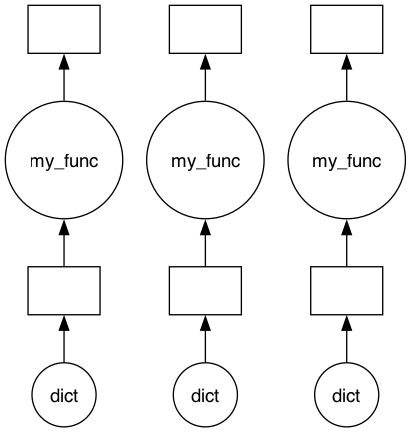

In [9]:
from graphviper.graph_tools.map import map
import dask
from graphviper.utils.display import dict_to_html
from IPython.display import display, HTML


def my_func(input_parms):
    display(HTML(dict_to_html(input_parms)))

    print("*" * 30)
    return input_parms["test_input"]


input_parms = {}
input_parms["test_input"] = 42

graph = map(
    input_data=ps,
    node_task_data_mapping=node_task_data_mapping,
    node_task=my_func,
    input_parms=input_parms,
)

dask.visualize(graph, filename="map_graph")

In [10]:
graph

([Delayed('my_func-3110e683-399d-41ac-901d-f509dd126c67'),
  Delayed('my_func-e8feb879-355a-4a78-abe7-d0bbf5d581fd'),
  Delayed('my_func-28dd3943-e00b-4f25-9655-5d84db837e72')],
 None)

### Run Map Graph

In [11]:
dask.compute(graph)

******************************


******************************


******************************


(([42, 42, 42], None),)

### Reduce Graph

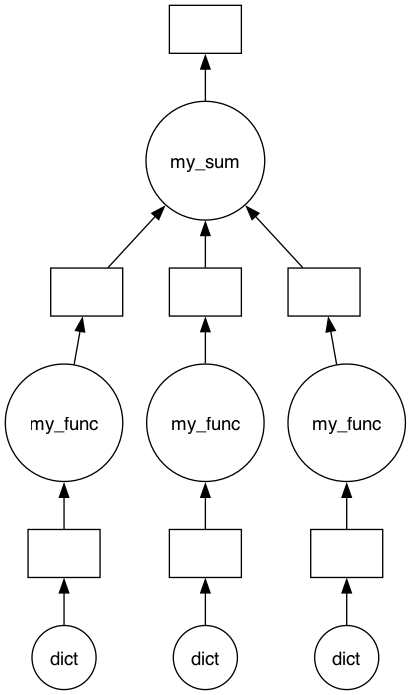

In [12]:
from graphviper.graph_tools import reduce
import numpy as np


def my_sum(graph_inputs, input_parms):
    print(graph_inputs)
    return np.sum(graph_inputs) + input_parms["test_input"]


input_parms = {}
input_parms["test_input"] = 5
graph_reduce = reduce(
    graph, my_sum, input_parms, mode="single_node"
)  # mode "tree","single_node"
dask.visualize(graph_reduce)

### Run Map Reduce Graph

In [13]:
dask.compute(graph_reduce)

******************************


******************************


******************************
[42, 42, 42]


([131, None],)

## Overlapping Frequency Map Reduce

### Create Parallel Coordinates

In [14]:
from graphviper.utils.display import dict_to_html
import dask

dask.config.set(scheduler="synchronous")
from xradio.vis.read_processing_set import read_processing_set
from IPython.display import HTML, display


ps = read_processing_set(
    ps_name="Antennae_North.cal.lsrk.split.vis.zarr",
    intents=["OBSERVE_TARGET#ON_SOURCE"],
)
ms_xds = ps.get(1)
n_chunks = 3

parallel_coords = {}
freq_coord = ms_xds.frequency.to_dict()
freq_coord["data_chunks"] = {
    0: freq_coord["data"][0:4],
    1: freq_coord["data"][3:7],
    2: freq_coord["data"][4:8],
}
parallel_coords["frequency"] = freq_coord

display(HTML(dict_to_html(parallel_coords["frequency"])))

### Create Node Task Data Mapping

In [15]:
from graphviper.graph_tools.coordinate_utils import (
    interpolate_data_coords_onto_parallel_coords,
)

node_task_data_mapping = interpolate_data_coords_onto_parallel_coords(
    parallel_coords, ps
)
display(HTML(dict_to_html(node_task_data_mapping)))

### Map Graph

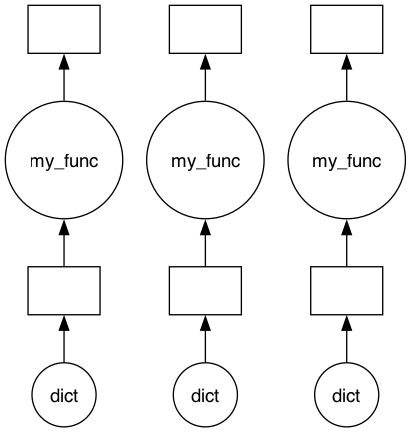

In [16]:
from graphviper.graph_tools.map import map
import dask
from IPython.display import display, HTML
from xradio.vis.read_processing_set import read_processing_set


def my_func(input_parms):
    display(HTML(dict_to_html(input_parms)))

    print("*" * 30)
    return input_parms["test_input"]


# ['test_input', 'input_data_name', 'viper_local_dir', 'date_time', 'data_sel', 'chunk_coords', 'chunk_indx', 'chunk_id', 'parallel_dims']
input_parms = {}
input_parms["test_input"] = 42

ps = read_processing_set(
    ps_name="Antennae_North.cal.lsrk.split.vis.zarr",
    intents=["OBSERVE_TARGET#ON_SOURCE"],
)

graph = map(
    input_data=ps,
    node_task_data_mapping=node_task_data_mapping,
    node_task=my_func,
    input_parms=input_parms,
)

dask.visualize(graph, filename="map_graph")

### Run Map Graph

In [17]:
dask.compute(graph)

******************************


******************************


******************************


(([42, 42, 42], None),)

## Baseline and Frequency Map Reduce

### Create Parallel Coordinates

In [18]:
from graphviper.utils.display import dict_to_html
from graphviper.graph_tools.coordinate_utils import make_parallel_coord
import dask

dask.config.set(scheduler="synchronous")

from xradio.vis.read_processing_set import read_processing_set

from IPython.display import HTML, display

intents = ["OBSERVE_TARGET#ON_SOURCE"]
ps = read_processing_set(
    ps_name="Antennae_North.cal.lsrk.split.vis.zarr",
    intents=["OBSERVE_TARGET#ON_SOURCE"],
)
ms_xds = ps.get(1)

parallel_coords = {}

import xarray as xr
import numpy as np

n_chunks = 4
parallel_coords["baseline_id"] = make_parallel_coord(
    coord=ms_xds.baseline_id, n_chunks=n_chunks
)

n_chunks = 3
parallel_coords["frequency"] = make_parallel_coord(
    coord=ms_xds.frequency, n_chunks=n_chunks
)

display(HTML(dict_to_html(parallel_coords)))

### Create Node Task Data Mapping

In [19]:
from graphviper.graph_tools.coordinate_utils import (
    interpolate_data_coords_onto_parallel_coords,
)

node_task_data_mapping = interpolate_data_coords_onto_parallel_coords(
    parallel_coords, ps
)
display(HTML(dict_to_html(node_task_data_mapping)))

### Map Graph

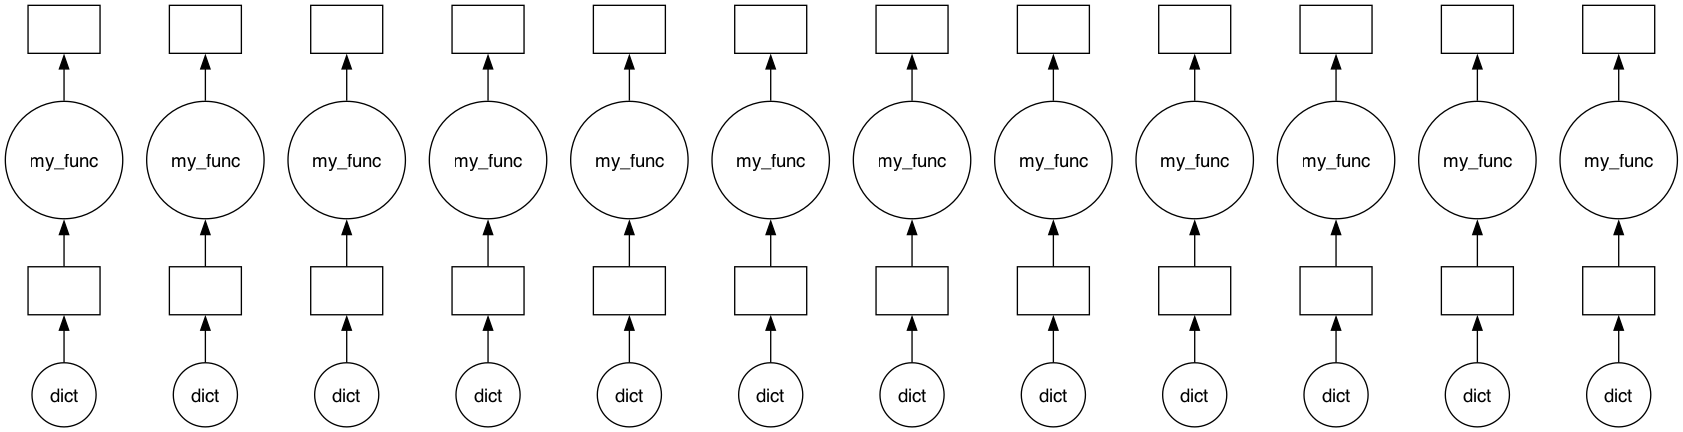

In [20]:
from graphviper.graph_tools.map import map
import dask
from IPython.display import display, HTML


def my_func(input_parms):
    display(HTML(dict_to_html(input_parms)))

    print("*" * 30)
    return input_parms["test_input"]


# ['test_input', 'input_data_name', 'viper_local_dir', 'date_time', 'data_sel', 'chunk_coords', 'chunk_indx', 'chunk_id', 'parallel_dims']
input_parms = {}
input_parms["test_input"] = 42

graph = map(
    input_data=ps,
    node_task_data_mapping=node_task_data_mapping,
    node_task=my_func,
    input_parms=input_parms,
)

dask.visualize(graph, filename="map_graph")

### Run Map Graph

In [21]:
dask.compute(graph)

******************************


******************************


******************************


******************************


******************************


******************************


******************************


******************************


******************************


******************************


******************************


******************************


(([42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42], None),)

## Time Map Reduce

### Create Parallel Coordinates

In [22]:
from graphviper.graph_tools.coordinate_utils import make_parallel_coord
from graphviper.utils.display import dict_to_html
import dask

dask.config.set(scheduler="synchronous")

from xradio.vis.read_processing_set import read_processing_set
from IPython.display import HTML, display

intents = ["OBSERVE_TARGET#ON_SOURCE"]
ps = read_processing_set(
    ps_name="Antennae_North.cal.lsrk.split.vis.zarr",
    intents=["OBSERVE_TARGET#ON_SOURCE"],
)
ms_xds = ps.get(1)

parallel_coords = {}

import xarray as xr
import numpy as np

t0, t1, t2 = (ps.get(1).time, ps.get(0).time, ps.get(2).time)
time_coord = xr.concat([t0, t1, t2], dim="time").sortby("time").to_dict()
n_chunks = 4
parallel_coords["time"] = make_parallel_coord(coord=time_coord, n_chunks=n_chunks)
display(HTML(dict_to_html(parallel_coords["time"])))

### Create Node Task Data Mapping

In [23]:
from graphviper.graph_tools.coordinate_utils import (
    interpolate_data_coords_onto_parallel_coords,
)

node_task_data_mapping = interpolate_data_coords_onto_parallel_coords(
    parallel_coords, ps
)
display(HTML(dict_to_html(node_task_data_mapping)))

### Map Graph

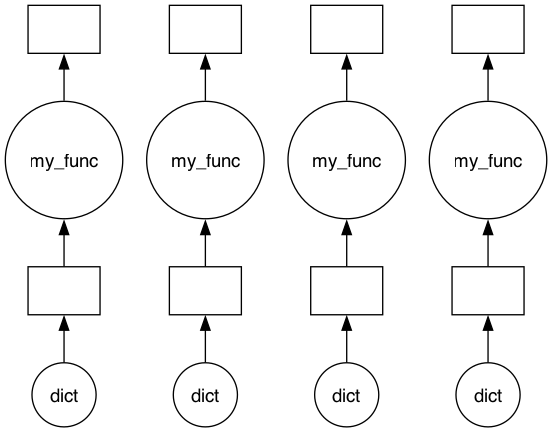

In [24]:
from graphviper.graph_tools.map import map
import dask
from IPython.display import display, HTML


def my_func(input_parms):
    display(HTML(dict_to_html(input_parms)))

    print("*" * 30)
    return input_parms["test_input"]


# ['test_input', 'input_data_name', 'viper_local_dir', 'date_time', 'data_sel', 'chunk_coords', 'chunk_indx', 'chunk_id', 'parallel_dims']
input_parms = {}
input_parms["test_input"] = 42

graph = map(
    input_data=ps,
    node_task_data_mapping=node_task_data_mapping,
    node_task=my_func,
    input_parms=input_parms,
)

dask.visualize(graph, filename="map_graph")

### Run Map Graph

In [25]:
dask.compute(graph)

******************************


******************************


******************************


******************************


(([42, 42, 42, 42], None),)